In [112]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
import re
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from subprocess import check_output

import warnings

def ignore_warn(*args ,**kwargs):
    pass
warnings.warn = ignore_warn
train = pd.read_csv("./data/train_20171226.csv")
train.shape

(20157, 32)

# 填充'-', 类型转换

In [113]:
train['level_id'][train['level_id']=='-'] = '0'
#TR
train['TR'][train['TR']=='8;7']='8'
train['TR'][train['TR']=='5;4']='5'
#engine_torque
train['engine_torque'][train['engine_torque']=='-'] = '210'
train['engine_torque'][train['engine_torque']=='155/140'] = '155'
#fuel_type_id
train['fuel_type_id'][train['fuel_type_id']=='-']=1
#power
train['power'][train['power']=='81/70'] = '81'
#rated_passenger
train['rated_passenger'][train['rated_passenger']=='4月5日'] = '5'
train['rated_passenger'][train['rated_passenger']=='5月7日'] = '7'
train['rated_passenger'][train['rated_passenger']=='5月8日'] = '7'
train['rated_passenger'][train['rated_passenger']=='9'] = '7'
train['rated_passenger'][train['rated_passenger']=='6月7日'] = '6'
train['rated_passenger'][train['rated_passenger']=='6月8日'] = '6'
train['rated_passenger'][train['rated_passenger']=='7月8日'] = '8'

In [114]:
#price使用中位数填充
train['price'][train['price']=='-'] = np.nan
all_class = train['class_id'].unique().tolist()
for id in all_class:
    train['price'][train['class_id']==id] = train['price'][train['class_id']==id].fillna(train['price'][train['class_id']==id].median())
train['price'] = train['price'].fillna('-')
#price使用price_level均值填充
temp_data = []
for data in train['price_level'][train['price']=='-']:
    temp_data.append(sum([int(i) for i in re.findall(r'\d+', data)]))   
j = 0
for i in range(train['price'].shape[0]):
    if train['price'][i] == '-':
        if temp_data[j] >= 10:
            train['price'][i] = temp_data[j]/2.0
        else:
            train['price'][i] = temp_data[j]
        j+=1
train['price'] = train['price'].astype(float)

In [115]:
#转换类型
train['TR']=train['TR'].astype(int)
train['fuel_type_id']=train['fuel_type_id'].astype(int)
train['power']=train['power'].astype(float)
train['engine_torque']=train['engine_torque'].astype(float)
train['rated_passenger']=train['rated_passenger'].astype(int)
train['level_id']=train['level_id'].astype(int)

#定性特征转换
train['if_charging'] = train['if_charging'].map({'L':0, 'T':1})
train['if_MPV_id'] = train['if_MPV_id'].map({1:0, 2:1})
train['if_luxurious_id'] = train['if_luxurious_id'].map({1:0, 2:1})
train['newenergy_type_id'] = train['newenergy_type_id'].map({1:1, 2:2, 3:3, 4:2})
title_mapping = {"5WL": 1, "5-8W": 2, "8-10W": 3, "10-15W": 4, "15-20W": 5, "20-25W": 6, "25-35W": 7, "35-50W": 8, "50-75W": 9,}
train['price_level'] = train['price_level'].map(title_mapping)

# OneHotEncoder

In [116]:
#one_hot_feat = ['fuel_type_id', 'driven_type_id', 'emission_standards_id', 'newenergy_type_id','rated_passenger', 
#                'cylinder_number', 'type_id', 'compartment', 'level_id', 'department_id', 'gearbox_type', 'TR']
#train[one_hot_feat] = train[one_hot_feat].astype(str)
#train = pd.get_dummies(train)

# LabelEncoder

In [117]:
le_feat = ['brand_id', 'gearbox_type']
lbl = LabelEncoder()
for feat in le_feat:
    lbl.fit(list(train[feat])) 
    train[feat] = lbl.transform(train[feat])

# 特征缩放

In [118]:
mascaler_feat = ['engine_torque','car_length','car_width','car_height','total_quality',
                 'equipment_quality','wheelbase','front_track','rear_track']
scaler = MaxAbsScaler()
scaler.fit(train[mascaler_feat].values)
train[mascaler_feat] = scaler.transform(train[mascaler_feat])
train.shape

(20157, 32)

# 处理price_level特征, feature.py

In [119]:
init_train = pd.read_csv("./data/train_20171226.csv")
test = pd.read_csv("./data/test_20171225.csv")
price_level = init_train[['price_level', 'class_id']]

In [120]:
#添加low_price, mean_price, high_prcie
price_level['low_price'] = price_level['price_level'].map({'5WL':3, '5-8W':5, '8-10W':8, 
                            '10-15W':10, '15-20W':15, '20-25W':20, '25-35W':25, '35-50W':35, '50-75W':50})
price_level['mean_price'] = price_level['price_level'].map({'5WL':4, '5-8W':7.5, '8-10W':9, 
                            '10-15W':12.5, '15-20W':17.5, '20-25W':22.5, '25-35W':30, '35-50W':42.5, '50-75W':62.5})
price_level['high_price'] = price_level['price_level'].map({'5WL':5, '5-8W':8, '8-10W':10, 
                            '10-15W':15, '15-20W':20, '20-25W':25, '25-35W':35, '35-50W':50, '50-75W':75})
train['low_price'] = price_level['low_price']
train['mean_price'] = price_level['mean_price']
train['high_price'] = price_level['high_price']
#添加discount_price, raise_price
train['discount_price'] = 0
train['discount_price'][train['price']<train['low_price']] = 1
train['raise_price'] = 0
train['raise_price'][train['price']>train['high_price']] = 1

# 处理sale_date特征

In [121]:
train['sale_month'] = train['sale_date']%100
train['sale_year'] = train['sale_date']//100%100
test['sale_month'] = test['predict_date']%100
test['sale_year'] = test['predict_date']//100%100
#添加时间特征latest和passed
train['latest'] = 0
train['passed'] = 0
for i in range(train['class_id'].count()):
    id = train['class_id'][i]
    min_date = train["sale_date"][train['class_id']==id].min()
    max_date = train["sale_date"][train['class_id']==id].max()
    loc_date = train["sale_date"][i]
    train["latest"][i] = (loc_date//100%100- min_date//100%100)*12+(loc_date%100- min_date%100)
    train["passed"][i] = (max_date//100%100- loc_date//100%100)*12+(max_date%100- loc_date%100)
test['latest'] = 0
test['passed'] = 0
for i in range(test['class_id'].count()):
    id = test['class_id'][i]
    min_date = train["sale_date"][train['class_id']==id].min()
    max_date = test["predict_date"][test['class_id']==id].max()
    loc_date = test["predict_date"][i]
    test["latest"][i] = (loc_date//100%100- min_date//100%100)*12+(loc_date%100- min_date%100)
    test["passed"][i] = (max_date//100%100- loc_date//100%100)*12+(max_date%100- loc_date%100)

# 合并数据集,同一class_id每月只有一次,依据为销量最高

In [188]:
merge_train = pd.DataFrame()
all_class_id = train['class_id'].unique().tolist()
for idx in all_class_id:
    all_month = train['sale_date'][train['class_id']==idx].unique().tolist()
    for mon in all_month:
        max_val = train['sale_quantity'][train['class_id']==idx][train['sale_date']==mon].max()
        sale_sum = train['sale_quantity'][train['class_id']==idx][train['sale_date']==mon].sum()
        feat_val = train[train['class_id']==idx][train['sale_date']==mon][train['sale_quantity']==max_val]
        feat_val['sale_quantity'] = sale_sum
            merge_train = pd.concat([merge_train, feat_val[0:1]])
#含有相同销量的同一class_id
merge_train = merge_train.sort_values(by=['sale_date'], ascending=True)

# 填充test datasets 特征

In [189]:
#找出销量最高的特征进行填充
cols = merge_train.columns.tolist()
test = test.ix[:,cols]
test['sale_date'] = test['sale_date'].fillna(201711)
test['sale_date'] = test['sale_date'].astype(int)

drop_col = ['sale_date', 'class_id', 'sale_quantity', 'sale_month', 'sale_year', 'latest', 'passed']
for co in drop_col:
    cols.remove(co)

all_class_id = test['class_id'].unique().tolist()
for idx in all_class_id:
    for c in cols:
        feat_data = train[[c, 'sale_quantity']][train['class_id']==idx].groupby([c], as_index=False).sum()
        max_val = feat_data['sale_quantity'].max()
        test[c][test['class_id']==idx] = list(feat_data[c][feat_data['sale_quantity']==max_val])[0]

In [190]:
#单独填充price,discount_price,rsise_price
for idx in all_class_id:
    feat_data = train[['price', 'sale_quantity']][train['class_id']==idx].groupby(['price'], as_index=False).sum()
    feat_data['total_price'] = feat_data['price']*feat_data['sale_quantity']
    total_sale = feat_data['sale_quantity'].sum()
    mean_price = feat_data['total_price'].sum()/total_sale
    test['price'][test['class_id']==idx] = mean_price
test['discount_price'] = 0
test['discount_price'][test['price']<test['low_price']] = 1
train['raise_price'] = 0
test['raise_price'][test['price']>test['high_price']] = 1

In [191]:
#添加量差特征，即本月与上月销量差距
temp_train = merge_train.sort_values(['class_id', 'sale_date'])
temp_train['diff_quantity'] = np.nan
temp_train['growth_rate'] = np.nan
all_class_id = temp_train['class_id'].unique().tolist()
for idx in all_class_id:
    one_id = temp_train.loc[temp_train['class_id']==idx]
    all_date = one_id['sale_date'].unique().tolist()
    for i in range(len(all_date)-1):
        last = list(one_id['sale_quantity'].loc[one_id['sale_date']==all_date[i]])[0]
        now = list(one_id['sale_quantity'].loc[one_id['sale_date']==all_date[i+1]])[0]
        temp_train['diff_quantity'].loc[(temp_train['class_id']==idx)&(temp_train['sale_date']==all_date[i+1])] = now-last
        temp_train['growth_rate'].loc[(temp_train['class_id']==idx)&(temp_train['sale_date']==all_date[i+1])] = (now-last)/now
merge_train = temp_train.sort_index()

In [194]:
#预测训练集首月diff_quantity, growth_rated缺失值
import xgboost as xgb
xgboost_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xc = ['sale_quantity']+['brand_id']+['sale_month']+['sale_year']
xtrain = merge_train[merge_train['diff_quantity'].notnull()]
xtr = xtrain[:][xc]
xtest = merge_train[merge_train['diff_quantity'].isnull()]
xte = xtest[:][xc]
y_diff_train = merge_train['diff_quantity'][merge_train['diff_quantity'].notnull()]
y_grow_train = merge_train['growth_rate'][merge_train['diff_quantity'].notnull()]
xgboost_model.fit(xtr, y_diff_train)
diff = xgboost_model.predict(xte)
xgboost_model.fit(xtr, y_grow_train)
grow = xgboost_model.predict(xte)
xtest['diff_quantity'] = diff
xtest['growth_rate'] = grow
for idx in all_class_id:
    merge_train['diff_quantity'].loc[(merge_train['class_id']==idx)&(merge_train['diff_quantity'].isnull())]=xtest['diff_quantity'][xtest['class_id']==idx]
    merge_train['growth_rate'].loc[(merge_train['class_id']==idx)&(merge_train['growth_rate'].isnull())]=xtest['growth_rate'][xtest['class_id']==idx]

In [204]:
#填充测试集首月diff_quantity, growth_rated缺失值
x_train = merge_train[:][xc]
x_test = test
x_test = x_test[:][xc]
y_diff_train = merge_train['diff_quantity']
y_grow_train = merge_train['growth_rate']
xgboost_model.fit(x_train, y_diff_train)
diff = xgboost_model.predict(x_test)
xgboost_model.fit(x_train, y_grow_train)
grow = xgboost_model.predict(x_test)
test['diff_quantity'] = diff
test['growth_rate'] = grow

In [ ]:
#填充测试集首月diff_quantity, growth_rated缺失值
test['diff_quantity'] = np.nan
test['growth_rate'] = np.nan
for idx in all_class_id:
    diff = merge_train['diff_quantity'].loc[(merge_train['class_id']==idx)&(merge_train['sale_month']==11)].mean()
    grow = merge_train['growth_rate'].loc[(merge_train['class_id']==idx)&(merge_train['sale_month']==11)].mean()
    test['diff_quantity'].loc[test['class_id']==idx] = diff
    test['growth_rate'].loc[test['class_id']==idx] = grow
test = test.fillna(0)

# baseline

In [167]:
#读取已添加特征后数据集
#train = pd.read_csv('feature_train20180201_195350.csv')
#test = pd.read_csv('feature_test20180201_195350.csv')
train = merge_train
train_x = train.drop(['sale_date', 'sale_quantity'], axis=1)
train_y = train['sale_quantity']
test_x = test.drop(['sale_date'], axis=1)

In [168]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb

In [182]:
#类型转换
cols = train_x.columns.tolist()
for c in cols:
    test_x[c] = test_x[c].astype(train_x[c].dtypes)
all_data = pd.concat((train_x, test_x)).reset_index(drop=True)
all_data = all_data.ix[:,cols]

#对class_id LabelEncoder
lbl = LabelEncoder()
lbl.fit(list(all_data['class_id'])) 
all_data['class_id'] = lbl.transform(all_data['class_id'])
all_data = pd.concat((train_x, test_x)).reset_index(drop=True)
all_data = all_data.ix[:,cols]
lbl = LabelEncoder()
lbl.fit(list(all_data['class_id'])) 
all_data['class_id'] = lbl.transform(all_data['class_id'])

one_hot_feat = ['fuel_type_id', 'driven_type_id', 'emission_standards_id', 'newenergy_type_id','rated_passenger', 
                'cylinder_number', 'type_id', 'compartment', 'level_id', 'department_id', 'gearbox_type', 'TR', 'sale_month']
all_data[one_hot_feat] = all_data[one_hot_feat].astype(str)
#train = pd.get_dummies(train)
#OneHotEncoder 月
#all_data['sale_month'] = all_data['sale_month'].astype(str)
all_data = pd.get_dummies(all_data)

train_x = all_data[:len(train_x)]
test_x = all_data[len(train_x):]

In [185]:
def rmsle_cv(model, train_x, train_y):
    n_folds = 3
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_x)
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#xgb
def xgb_Regressor(train_x, train_y, test_x):
    xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
    scores = rmsle_cv(xgb_model, train_x, train_y)
    
    xgb_model.fit(train_x, train_y)
    pred_train = xgb_model.predict(train_x)
    score = rmsle(train_y, pred_train)
    
    return xgb_model, scores.mean(), score

In [186]:
print("XGBOOSTRegressor开始训练...")
xgb_model, scores, score = xgb_Regressor(train_x, train_y, test_x)
print(scores, score)

XGBOOSTRegressor开始训练...
153.316810379 57.1243092085


In [187]:
train_x.head()

,class_id,brand_id,displacement,if_charging,price_level,price,if_MPV_id,if_luxurious_id,power,engine_torque,car_length,car_width,car_height,total_quality,equipment_quality,wheelbase,front_track,rear_track,low_price,mean_price,high_price,discount_price,raise_price,sale_year,latest,passed,diff_quantity,growth_rate,compartment_1,compartment_2,compartment_3,type_id_1,type_id_2,type_id_3,type_id_4,level_id_0,level_id_1,level_id_2,level_id_3,level_id_4,level_id_5,department_id_1,department_id_2,department_id_3,department_id_4,department_id_5,department_id_6,department_id_7,TR_0,TR_1,TR_4,TR_5,TR_6,TR_7,TR_8,TR_9,gearbox_type_0,gearbox_type_1,gearbox_type_2,gearbox_type_3,gearbox_type_4,gearbox_type_5,gearbox_type_6,driven_type_id_1,driven_type_id_2,driven_type_id_3,fuel_type_id_1,fuel_type_id_4,newenergy_type_id_1,newenergy_type_id_3,emission_standards_id_1,emission_standards_id_2,emission_standards_id_3,cylinder_number_0,cylinder_number_3,cylinder_number_4,cylinder_number_6,rated_passenger_4,rated_passenger_5,rated_passenger_6,rated_passenger_7,rated_passenger_8,sale_month_1,sale_month_10,sale_month_11,sale_month_12,sale_month_2,sale_month_3,sale_month_4,sale_month_5,sale_month_6,sale_month_7,sale_month_8,sale_month_9
0,24,0,1.8,0,3,9.5,1,0,98.0,0.386364,0.843145,0.943872,0.788265,0.672619,0.658354,0.868726,0.940181,0.934770,8,9.0,10,0,0,16,4,13,102.0,0.459459,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,110,18,1.6,0,4,13.2,1,0,94.0,0.361364,0.860995,0.938723,0.756633,0.678968,0.666334,0.851995,0.938369,0.923998,10,12.5,15,0,0,16,52,13,369.0,0.298061,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,102,28,1.8,0,4,14.4,1,0,105.0,0.400000,0.896316,0.934604,0.747449,0.738095,0.727681,0.891248,0.954079,0.950928,10,12.5,15,0,0,16,24,13,149.0,0.586614,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,13,19,1.5,1,4,11.1,1,0,110.0,0.477273,0.823205,0.934089,0.864796,0.751984,0.758105,0.823681,0.921450,0.909635,10,12.5,15,0,0,16,25,13,-10.0,-0.043478,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,67,34,2.0,1,8,44.3,1,1,155.0,0.795455,0.885112,0.977343,0.848980,0.936508,0.927681,0.924389,0.977039,0.965290,35,42.5,50,0,0,16,9,13,-84.0,-0.770642,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [181]:
#提交
xgb_pred = xgb_model.predict(test_x)
sub = pd.read_csv("./data/test_20171225.csv")
sub['predict_quantity'] = xgb_pred
sub.to_csv('submission_diff_grow.csv',index=False)

In [24]:
#lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [30]:
train.head()

,sale_date,class_id,sale_quantity,brand_id,displacement,if_charging,price_level,price,if_MPV_id,if_luxurious_id,power,engine_torque,car_length,car_width,car_height,total_quality,equipment_quality,wheelbase,front_track,rear_track,compartment_1,compartment_2,compartment_3,type_id_1,type_id_2,type_id_3,type_id_4,level_id_0,level_id_1,level_id_2,level_id_3,level_id_4,level_id_5,department_id_1,department_id_2,department_id_3,department_id_4,department_id_5,department_id_6,department_id_7,TR_0,TR_1,TR_4,TR_5,TR_6,TR_7,TR_8,TR_9,gearbox_type_AMT,gearbox_type_AT,gearbox_type_AT;DCT,gearbox_type_CVT,gearbox_type_DCT,gearbox_type_MT,gearbox_type_MT;AT,driven_type_id_1,driven_type_id_2,driven_type_id_3,fuel_type_id_1,fuel_type_id_2,fuel_type_id_3,fuel_type_id_4,newenergy_type_id_1,newenergy_type_id_2,newenergy_type_id_3,emission_standards_id_1,emission_standards_id_2,emission_standards_id_3,emission_standards_id_5,cylinder_number_0,cylinder_number_3,cylinder_number_4,cylinder_number_6,rated_passenger_4,rated_passenger_5,rated_passenger_6,rated_passenger_7,rated_passenger_8,low_price,mean_price,high_price,discount_price,raise_price,sale_month,sale_year,latest,passed
0,201201,354068,460,21,1.6,0,4,10.3,1,0,86.0,0.3477,0.8859,0.8754,0.7704,0.6587,0.6085,0.8687,0.8912,0.8857,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,10,12.5,15,0,0,1,12,0,69
1,201201,914348,660,22,1.4,0,4,8.4,1,0,63.0,0.3000,0.7539,0.8661,0.7459,0.6337,0.5596,0.7947,0.8840,0.8713,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,10,12.5,15,1,0,1,12,0,69
2,201201,321683,478,22,1.6,0,5,13.7,1,0,74.0,0.3295,0.8629,0.9063,0.7454,0.7500,0.6878,0.8295,0.9299,0.9144,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,15,17.5,20,1,0,1,12,0,69
3,201201,559132,428,21,2.0,0,6,20.2,1,0,104.0,0.4318,0.9210,0.9243,0.7526,0.7698,0.7401,0.8929,0.9426,0.9336,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,20,22.5,25,0,0,1,12,0,69
4,201201,453752,96,27,2.0,0,8,36.9,1,1,112.0,0.4545,0.8604,0.9356,0.7250,0.7579,0.7406,0.8880,0.9100,0.9186,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,35,42.5,50,0,0,1,12,0,69


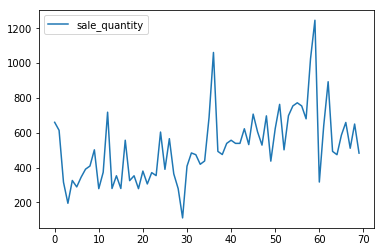

In [36]:
train_show = train
train_show['sale_quantity'] = train['sale_quantity']
show = train_show[['sale_date', 'sale_quantity']][train['class_id']==914348].groupby(['sale_date'], as_index=False).sum()
line2 = plt.plot(range(show.shape[0]),show['sale_quantity'],label=u'sale_quantity')
plt.legend()
plt.show()

In [39]:
train.head()

,sale_date,class_id,sale_quantity,brand_id,displacement,if_charging,price_level,price,if_MPV_id,if_luxurious_id,power,engine_torque,car_length,car_width,car_height,total_quality,equipment_quality,wheelbase,front_track,rear_track,compartment_1,compartment_2,compartment_3,type_id_1,type_id_2,type_id_3,type_id_4,level_id_0,level_id_1,level_id_2,level_id_3,level_id_4,level_id_5,department_id_1,department_id_2,department_id_3,department_id_4,department_id_5,department_id_6,department_id_7,TR_0,TR_1,TR_4,TR_5,TR_6,TR_7,TR_8,TR_9,gearbox_type_AMT,gearbox_type_AT,gearbox_type_AT;DCT,gearbox_type_CVT,gearbox_type_DCT,gearbox_type_MT,gearbox_type_MT;AT,driven_type_id_1,driven_type_id_2,driven_type_id_3,fuel_type_id_1,fuel_type_id_2,fuel_type_id_3,fuel_type_id_4,newenergy_type_id_1,newenergy_type_id_2,newenergy_type_id_3,emission_standards_id_1,emission_standards_id_2,emission_standards_id_3,emission_standards_id_5,cylinder_number_0,cylinder_number_3,cylinder_number_4,cylinder_number_6,rated_passenger_4,rated_passenger_5,rated_passenger_6,rated_passenger_7,rated_passenger_8,low_price,mean_price,high_price,discount_price,raise_price,sale_month,sale_year,latest,passed
0,201201,354068,460,21,1.6,0,4,10.3,1,0,86.0,0.3477,0.8859,0.8754,0.7704,0.6587,0.6085,0.8687,0.8912,0.8857,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,10,12.5,15,0,0,1,12,0,69
1,201201,914348,660,22,1.4,0,4,8.4,1,0,63.0,0.3000,0.7539,0.8661,0.7459,0.6337,0.5596,0.7947,0.8840,0.8713,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,10,12.5,15,1,0,1,12,0,69
2,201201,321683,478,22,1.6,0,5,13.7,1,0,74.0,0.3295,0.8629,0.9063,0.7454,0.7500,0.6878,0.8295,0.9299,0.9144,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,15,17.5,20,1,0,1,12,0,69
3,201201,559132,428,21,2.0,0,6,20.2,1,0,104.0,0.4318,0.9210,0.9243,0.7526,0.7698,0.7401,0.8929,0.9426,0.9336,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,20,22.5,25,0,0,1,12,0,69
4,201201,453752,96,27,2.0,0,8,36.9,1,1,112.0,0.4545,0.8604,0.9356,0.7250,0.7579,0.7406,0.8880,0.9100,0.9186,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,35,42.5,50,0,0,1,12,0,69


In [40]:
test.head()

,sale_date,class_id,brand_id,displacement,if_charging,price_level,price,if_MPV_id,if_luxurious_id,power,engine_torque,car_length,car_width,car_height,total_quality,equipment_quality,wheelbase,front_track,rear_track,compartment_1,compartment_2,compartment_3,type_id_1,type_id_2,type_id_3,type_id_4,level_id_0,level_id_1,level_id_2,level_id_3,level_id_4,level_id_5,department_id_1,department_id_2,department_id_3,department_id_4,department_id_5,department_id_6,department_id_7,TR_0,TR_1,TR_4,TR_5,TR_6,TR_7,TR_8,TR_9,gearbox_type_AMT,gearbox_type_AT,gearbox_type_AT;DCT,gearbox_type_CVT,gearbox_type_DCT,gearbox_type_MT,gearbox_type_MT;AT,driven_type_id_1,driven_type_id_2,driven_type_id_3,fuel_type_id_1,fuel_type_id_2,fuel_type_id_3,fuel_type_id_4,newenergy_type_id_1,newenergy_type_id_2,newenergy_type_id_3,emission_standards_id_1,emission_standards_id_2,emission_standards_id_3,emission_standards_id_5,cylinder_number_0,cylinder_number_3,cylinder_number_4,cylinder_number_6,rated_passenger_4,rated_passenger_5,rated_passenger_6,rated_passenger_7,rated_passenger_8,low_price,mean_price,high_price,discount_price,raise_price,sale_month,sale_year,latest,passed
0,201711,103507,28.0,1.6,0.0,4.0,13.3803,1.0,0.0,91.6,0.3425,0.8109,0.9166,0.8316,0.7262,0.6608,0.8333,0.9408,0.9396,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,12.5,15.0,0,0.0,11,17,32,0
1,201711,124140,24.0,1.8,1.0,4.0,13.1562,1.0,0.0,130.0,0.5227,0.8830,0.9526,0.8648,0.8234,0.8304,0.8687,0.9456,0.9366,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,12.5,15.0,0,0.0,11,17,42,0
2,201711,125403,23.0,2.4,0.0,8.0,29.4768,1.0,0.0,120.0,0.5114,0.9899,0.9670,0.9041,0.9802,0.9177,0.9936,0.9625,0.9581,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,35.0,42.5,50.0,1,0.0,11,17,70,0
3,201711,136916,6.0,2.0,0.0,5.0,19.8936,1.0,0.0,123.0,0.4318,0.9163,0.9398,0.7551,0.7937,0.7307,0.8929,0.9517,0.9336,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,15.0,17.5,20.0,0,0.0,11,17,70,0
4,201711,169673,20.0,1.5,1.0,2.0,8.0000,1.0,0.0,110.0,0.4886,0.8954,0.9423,0.9082,0.8313,0.7830,0.8880,0.9347,0.9276,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,7.5,8.0,0,0.0,11,17,5,0


In [48]:
y = train['sale_quantity']
X_train = train.drop(['sale_quantity'], axis=1)